In [1]:
'''
imports, constants, display settings
'''

import os
import math
import pandas as pd
import datetime as dt
import matplotlib.pylab as plt
import matplotlib.lines as mlines
import numpy as np
import seaborn as sns
from pandas.api.types import CategoricalDtype
from dateutil.relativedelta import relativedelta
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.utils import shuffle


class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

BASE_DIR = os.getcwd()
DATA_FP = os.path.join(BASE_DIR, 'loan.csv')

EARLIEST_ISSUE = dt.date(2007,6,1)
LAST_PAYMENT_DATE = dt.date(2016,1,1)
pd.options.display.max_columns = 999



In [2]:
'''
load the data into memory
'''
raw_data = pd.read_csv(DATA_FP, low_memory=False)

emp_title
51462


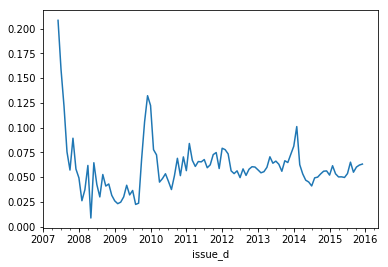

emp_length
44825


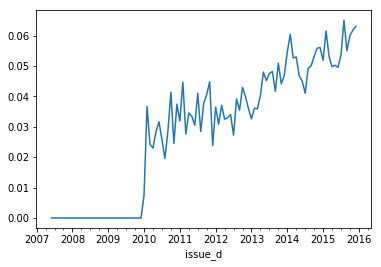

annual_inc
4


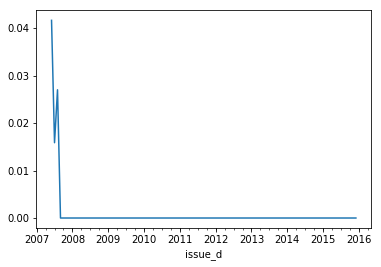

desc
761351


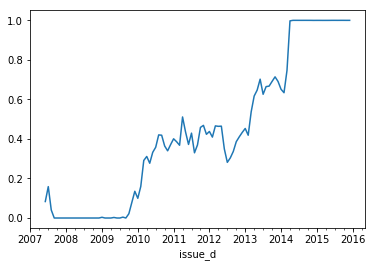

title
152


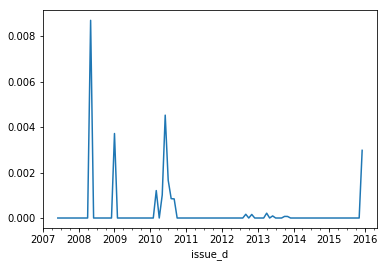

delinq_2yrs
29


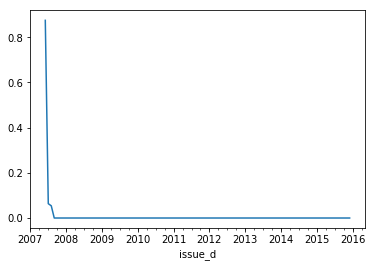

earliest_cr_line
29


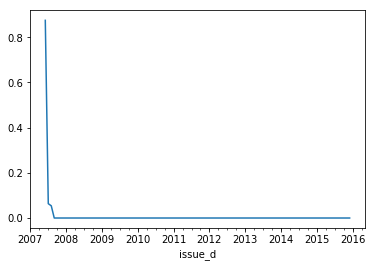

inq_last_6mths
29


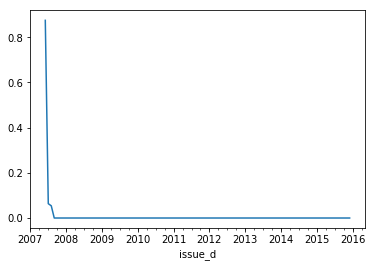

mths_since_last_delinq
454312


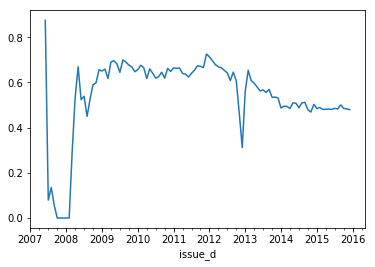

mths_since_last_record
750326


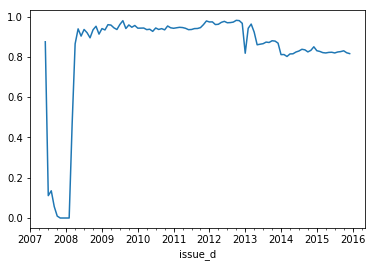

open_acc
29


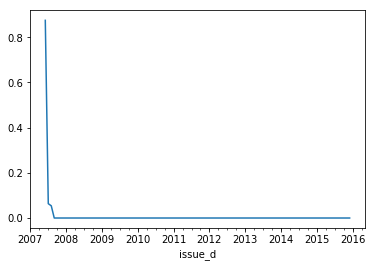

pub_rec
29


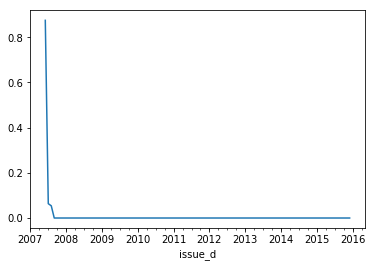

revol_util
502


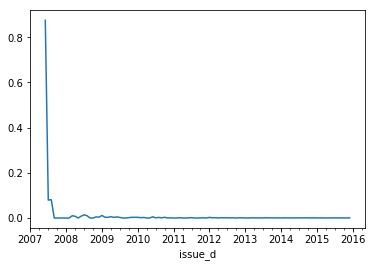

total_acc
29


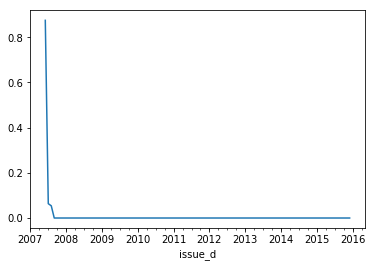

last_pymnt_d
17659


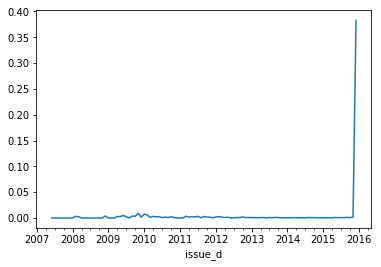

next_pymnt_d
252971


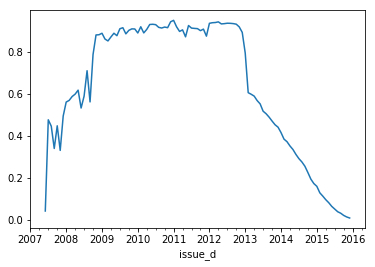

last_credit_pull_d
53


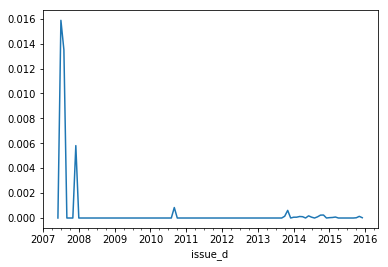

collections_12_mths_ex_med
145


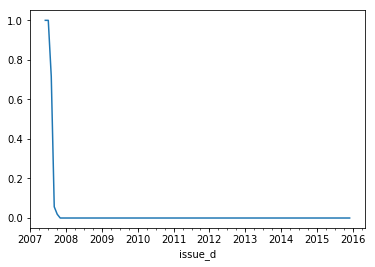

mths_since_last_major_derog
665676


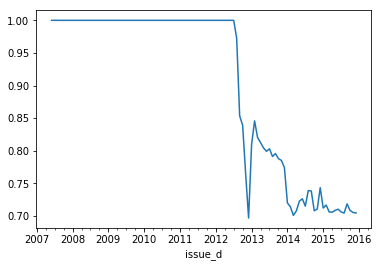

annual_inc_joint
886868


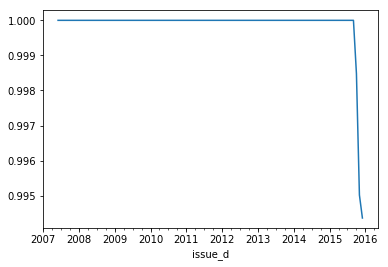

dti_joint
886870


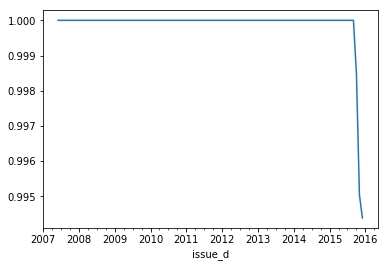

verification_status_joint
886868


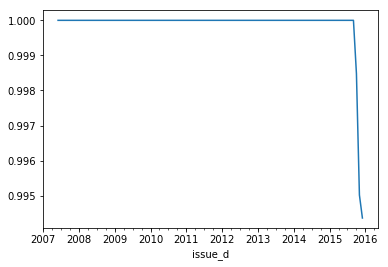

acc_now_delinq
29


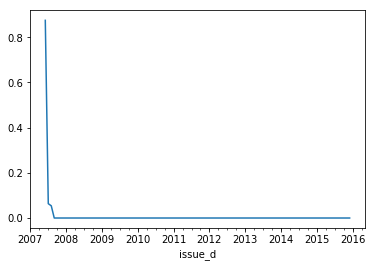

tot_coll_amt
70276


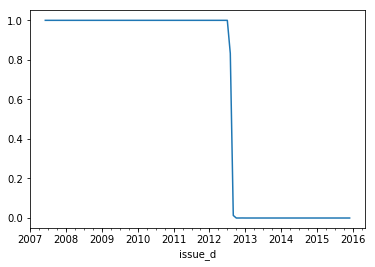

tot_cur_bal
70276


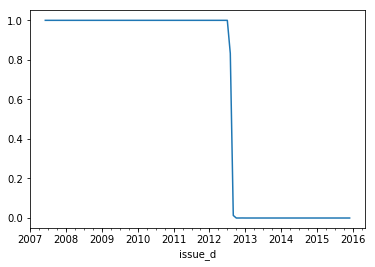

open_acc_6m
866007


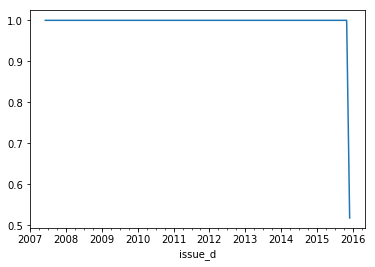

open_il_6m
866007


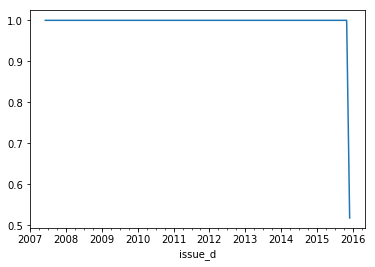

open_il_12m
866007


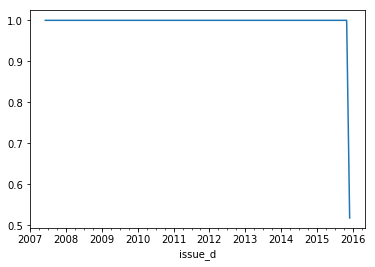

open_il_24m
866007


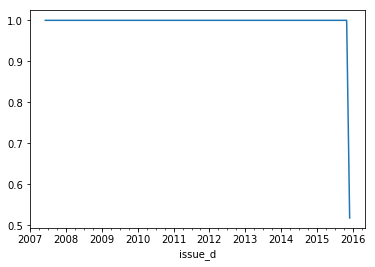

mths_since_rcnt_il
866569


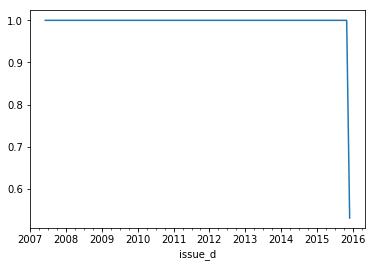

total_bal_il
866007


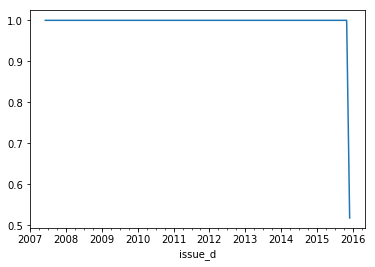

il_util
868762


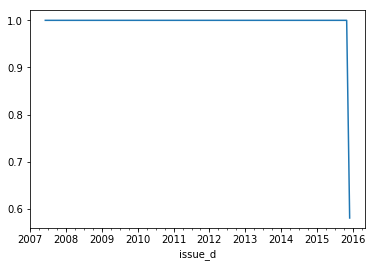

open_rv_12m
866007


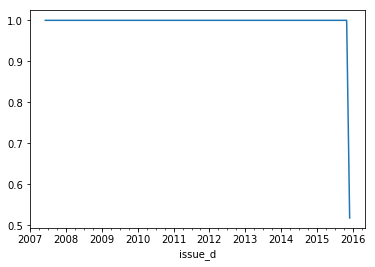

open_rv_24m
866007


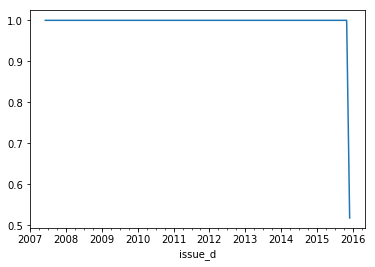

max_bal_bc
866007


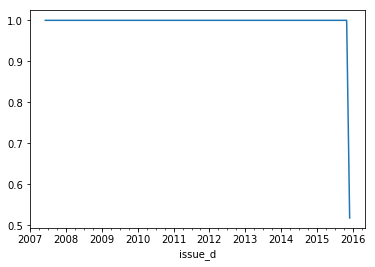

all_util
866007


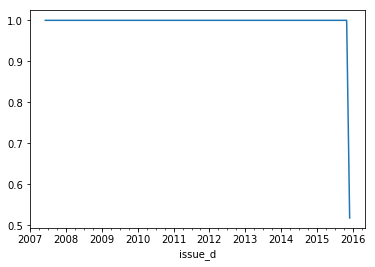

total_rev_hi_lim
70276


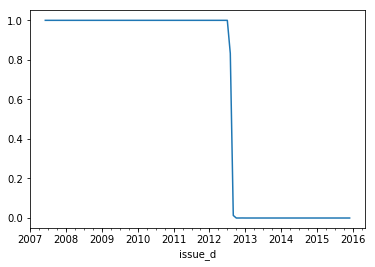

inq_fi
866007


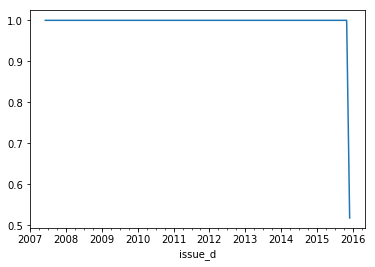

total_cu_tl
866007


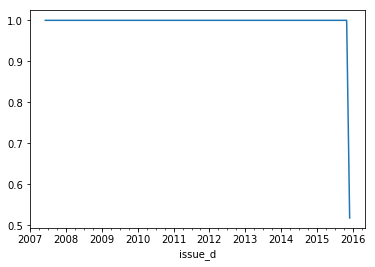

inq_last_12m
866007


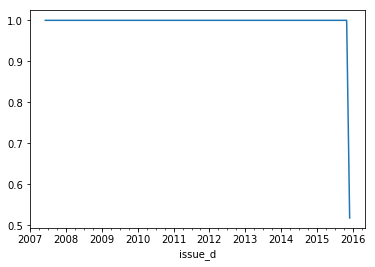

In [3]:
'''
Examine distributions and counts of missing values
'''

def NaN_over_time(df):
    '''
    for columns with missing values its useful to examine how they are distributed
    with respect to time.  Here we plot, percentage of records with null values over issue date.
    '''
    df.issue_d = pd.to_datetime(df.issue_d, format="%b-%Y")
    df = df.set_index(df.issue_d)
    for column in df.columns:
        s = df[column]
        if(s.isnull().sum() > 0):
            print(column)
            print(s.isnull().sum())
            s.groupby(s.index).apply(lambda x: 1 if x.size == 0 else x.isnull().sum() / x.size).plot()
            plt.show()


NaN_over_time(raw_data)

In [4]:
'''
drop rows and columns from data based upon frequency, distribution, and business logic
'''

def cull_data(df):
    
    #make sure we're mutating a copy not a view
    _df = df.copy()
    
    # drop id and member_id columns - each is unique in this dataset
    _df = _df.drop(['id', 'member_id'], axis=1)
    
    # potentially useful and interesting data, but NLP outof scope for initial modeling
    _df = _df.drop(['emp_title', 'title', 'desc', 'url'], axis =1)
    
    # drop 4 records with no annual income information
    _df = _df[~(_df.annual_inc.isnull())]

    # there are 29 early loans that lack a lot of information drop these rows
    _df = _df[~(_df.delinq_2yrs.isnull())]
    _df = _df[~(_df.earliest_cr_line.isnull())]
    _df = _df[~(_df.inq_last_6mths.isnull())]
    _df = _df[~(_df.open_acc.isnull())]
    _df = _df[~(_df.pub_rec.isnull())]
    _df = _df[~(_df.total_acc.isnull())]
        
    # drop 'mths_since_last_record' and 'mths_since_last_major_derog'.  
    # These columns are null for ~85% of records and are distributed strangly
    # w.r.t time.  indicating, lending club changed their data collection practices
    _df = _df.drop(['mths_since_last_record', 'mths_since_last_major_derog'], axis=1)
    
    # looking at the distributions of missing values w.r.t time shows that lending club
    # added many new data-elements in 2013 and 2015, these are unsuitable for modeling.
    _df = _df.drop(['annual_inc_joint', 'dti_joint', 'verification_status_joint',
                  'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 
                 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
                 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl',
                  'inq_last_12m'
                 ], axis=1)
    
    # these columns are binary-valued with over 99.9% of records taking the more common value.
    _df = _df[_df.pymnt_plan =="n"] # drop 10 rows
    _df = _df[_df.application_type =="INDIVIDUAL"] #drop 511 "JOINT" rows
    
    _df = _df.drop(['pymnt_plan', 'application_type', 'policy_code'], axis=1)
    return _df

print ("ORIGINAL DATA DIMENSIONS: {}".format(raw_data.shape))
data = cull_data(raw_data)
print ("NEW DATA DIMENSIONS: {}".format(data.shape))

ORIGINAL DATA DIMENSIONS: (887379, 74)
NEW DATA DIMENSIONS: (886829, 43)


In [5]:
'''
impute missing values and apply feature-level transformations
'''

def transform(df):
    
    _df = df.copy()
    
    #convert term to int: duration in months
    _df.term = _df.term.apply(lambda x : int(x.split(" ")[1]))

    # add column flagging were employement length was imputed
    _df['emp_length_imp'] = _df.emp_length.isnull().astype('int')
    
    # convert employemnt length to numeric and imputer missing values with median
    _df.emp_length = _df.emp_length.replace("< 1 year", "0")
    _df.emp_length = _df.emp_length.str.extract('(\d+)', expand=False)
    _df.emp_length = _df.emp_length.fillna(_df.emp_length.median()).astype('int')
    
    # Bin the mths_since_last_delinq field as there's no good way to
    # impute NaN values
    _df['mths_since_last_delinq_0_24'] = (_df.mths_since_last_delinq <= 24).astype(int)
    
    _df['mths_since_last_delinq_24_48'] = (
        (_df.mths_since_last_delinq > 24) & 
        (_df.mths_since_last_delinq <= 48)
    ).astype(int)
    
    _df['mths_since_last_delinq_48_72'] = (
        (_df.mths_since_last_delinq > 48) & 
        (_df.mths_since_last_delinq <= 72)
    ).astype(int)
    
    _df['mths_since_last_delinq_72_96'] = (
        (_df.mths_since_last_delinq > 72) & 
        (_df.mths_since_last_delinq <= 96)
    ).astype(int)
    
    _df['mths_since_last_delinq_96_inf'] = (
        (_df.mths_since_last_delinq > 96) 
    ).astype(int)
    
    _df = _df.drop('mths_since_last_delinq', axis=1)
    
    _df.revol_util = _df.revol_util.fillna(_df.revol_util.median())
    _df.collections_12_mths_ex_med = _df.collections_12_mths_ex_med.fillna(_df.collections_12_mths_ex_med.mode()[0])

    #convert to categorical with ordering
    grade_cats = CategoricalDtype(categories=['G', 'F', 'E', 'D', 'C', 'B',
                                              'A'], ordered=True) 
    _df.grade = _df.grade.astype(grade_cats)
    sub_grade_cats = CategoricalDtype(categories=[
        'G5', 'G4', 'G3', 'G2', 'G1',
        'F5', 'F4', 'F3', 'F2', 'F1',
        'E5', 'E4', 'E3', 'E2', 'E1',
        'D5', 'D4', 'D3', 'D2', 'D1',
        'C5', 'C4', 'C3', 'C2', 'C1',
        'B5', 'B4', 'B3', 'B2', 'B1',
        'A5', 'A4', 'A3', 'A2', 'A1',
    ], ordered=True)
    _df.sub_grade = _df.sub_grade.astype(sub_grade_cats)
    
    categorical_cols = [
        'home_ownership', 'verification_status', 'loan_status', 'purpose', 
        'zip_code', 'addr_state', 'initial_list_status'
    ]
    
    #convert to categoricals without ordering
    for col in categorical_cols:
        _df[col] = _df[col].astype("category")

    
    #convert to datetimes
    datetime_cols = [
        'issue_d', 'earliest_cr_line', 'last_pymnt_d',
        'next_pymnt_d', 'last_credit_pull_d'
    ]
    for col in datetime_cols:
        _df[col] = pd.to_datetime(_df[col], format="%b-%Y")
    
    #NaTs in last payment date indicate borrower didn't make a single payment
    _df.last_pymnt_d = _df.last_pymnt_d.fillna(_df.issue_d)

    #NaNs in next payment date column most likely indicate loan has been closed
    _df.next_pymnt_d = _df.next_pymnt_d.fillna(_df.last_pymnt_d)
    
    return(_df)
    

cleaned_data = transform(data)


In [6]:
'''
Enrich the data with derived fields
'''

def get_loan_duration(df):
    
    '''
    Best attempt to determine how long a given loan was (is) open.  This is NOT the loan-term. 
    ASSUMPTION - it takes a loan 150 days from the start of non-payment to charge-off.
    There are three cases that must be handled differently:
    
        1) loan is closed and fully paid
        2) loan is closed and charged off
        3) loan is open
    
    '''
    
    df['loan_duration'] = np.nan

    #case 1
    df.loc[
        (~df.loan_is_open) & 
        (df.loan_status.isin(
            ["Fully Paid", 
             "Does not meet the credit policy. Status:Fully Paid"
            ]
        )), "loan_duration"
    ] = round((df.last_pymnt_d - df.issue_d) / np.timedelta64(1,"M")) / 12
    
    df.loc[df.loan_duration == 0, "loan_duration"] = 1/12

    #case 2 - 150 days until it enters collection
    df.loc[
        (~df.loan_is_open) & 
        (df.loan_status.isin(
            ["Charged Off", 
             "Does not meet the credit policy. Status:Charged Off"
            ])), "loan_duration"
    ] = (
        ((df.last_pymnt_d - df.issue_d) + np.timedelta64(150,"D")) / np.timedelta64(1,"Y")
    )
    
    #case 3
    df.loc[
        df.loan_is_open, 
        'loan_duration'
    ] = (LAST_PAYMENT_DATE - df.issue_d) / np.timedelta64(1,"Y")

    return(df)


def get_performance_features(df):
    
    # represents percentage return of loan
    s = (df.total_pymnt - df.funded_amnt) / df.funded_amnt
    
    # raw ROI normalizes return over duration of loan
    df['raw_ROI'] = s / df.loan_duration
    
    # tern ROI normalizes return over term of loans 
    df['term_ROI'] = s/(df.term / 12)
    
    return df

    
def add_features(df):
    
    df['loan_is_open'] = df.loan_status.isin([
        'Current', 'Late (31-120 days)', 'Issued', 
        'In Grace Period', 'Late (16-30 days)', 'Default'
    ])
    
    df['maturity_d'] = pd.NaT
    df.loc[df.term == 36, 'maturity_d'] = df.issue_d + pd.offsets.DateOffset(years=3)
    df.loc[df.term == 60, 'maturity_d'] = df.issue_d + pd.offsets.DateOffset(years=5)
    
    df['earliest_cr_delta'] = (df.issue_d - df.earliest_cr_line).dt.days
    
    # total revoling credit limit
    df['revol_limit'] = df.revol_bal
    df.loc[df.revol_util != 0, "revol_limit"] = df.revol_bal / (df.revol_util / 100) 
    
    df['avg_revol_acc_limit'] = df.revol_limit
    df.loc[df.open_acc != 0, 'avg_revol_acc_limit'] = df.revol_limit / df.open_acc
    
    df['avg_revol_acc_bal'] = df.revol_bal
    df.loc[df.open_acc != 0, 'avg_revol_acc_bal'] = df.revol_bal / df.open_acc
    
    df['percentage_funded'] = df.funded_amnt_inv / df.loan_amnt
    
    df['inst_to_income'] = 1
    df.loc[df.annual_inc != 0, 'inst_to_income'] = df.installment / df.annual_inc
    
    return df

def enrich_data(df):
    _df = df.copy()
    return (_df.pipe(add_features).pipe(get_loan_duration).pipe(get_performance_features))
    
enriched_data = enrich_data(cleaned_data)

            

In [7]:
enriched_data.describe(include='all')

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,acc_now_delinq,emp_length_imp,mths_since_last_delinq_0_24,mths_since_last_delinq_24_48,mths_since_last_delinq_48_72,mths_since_last_delinq_72_96,mths_since_last_delinq_96_inf,loan_is_open,maturity_d,earliest_cr_delta,revol_limit,avg_revol_acc_limit,avg_revol_acc_bal,percentage_funded,inst_to_income,loan_duration,raw_ROI,term_ROI
count,886829.000000,886829.000000,886829.000000,886829.000000,886829.000000,886829.000000,886829,886829,886829.000000,886829,8.868290e+05,886829,886829,886829,886829,886829,886829,886829.000000,886829.000000,886829,886829.000000,886829.000000,886829.000000,8.868290e+05,886829.000000,886829.000000,886829,886829.000000,886829.000000,886829.000000,886829.000000,886829.000000,886829.000000,886829.000000,886829.000000,886829.000000,886829,886829.000000,886829,886777,886829.000000,886829.000000,886829.000000,886829.000000,886829.000000,886829.000000,886829.000000,886829.000000,886829,886829,886829.000000,8.868290e+05,8.868290e+05,886829.000000,886829.000000,886829.000000,886829.000000,886829.000000,886829.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,7,35,NaN,6,NaN,3,103,10,14,935,51,NaN,NaN,696,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98,NaN,100,103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,B,B3,NaN,MORTGAGE,NaN,Source Verified,2015-10-01 00:00:00,Current,debt_consolidation,945xx,CA,NaN,NaN,2001-08-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 00:00:00,NaN,2016-02-01 00:00:00,2016-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,2018-10-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,254422,56303,NaN,443193,NaN,329423,48557,601335,523874,9766,129451,NaN,NaN,6656,NaN,NaN,NaN,NaN,NaN,NaN,456668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,469848,NaN,552995,730059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,631141,37298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-06-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,1944-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-12-01 00:00:00,NaN,2007-12-01 00:00:00,2007-05-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-06-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-12-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,2012-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 00:00:00,NaN,2016-03-01 00:00:00,2016-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,14752.864476,14739.471589,14700.145025,43.198060,13.245712,436.660540,NaN,NaN,6.008367,NaN,7.503700e+04,NaN,NaN,NaN,NaN,NaN,NaN,18.126652,0.314412,NaN,0.694669,11.548682,0.195250,1.692204e+04,55.063546,25.268007,NaN,8397.189528,8393.787268,7562.817947,7525.240585,5760.827184,1755.652906,0.396677,45.941182,4.881506,NaN,2165.235872,NaN,NaN,0.014377,0.004993,0.050476,0.196543,0.162990,0.098585,0.029642,0.000251,NaN,NaN,5969.340271,3.745663e+04,3.399282e+03,1561.563280,0.995859,0.006644,1.131875,-1.490825,-0.130832
std,8434.231072,8428.662605,8440.747289,10.997341,4.381661,244.159479,NaN,NaN,3.572299,NaN,6.471070e+04,NaN,NaN,NaN,NaN,NaN,NaN,8.298517,0.862237,NaN,0.998539,5.317242,0.582059,2.243172e+04,23.828176,11.840340,NaN,8489.144251,8485.706011,7871.693851,7846.510895,6626.110169,2095.539328,4.086807,409.785980,63.117833,NaN,4796.056034,NaN,NaN,0.134172,0.

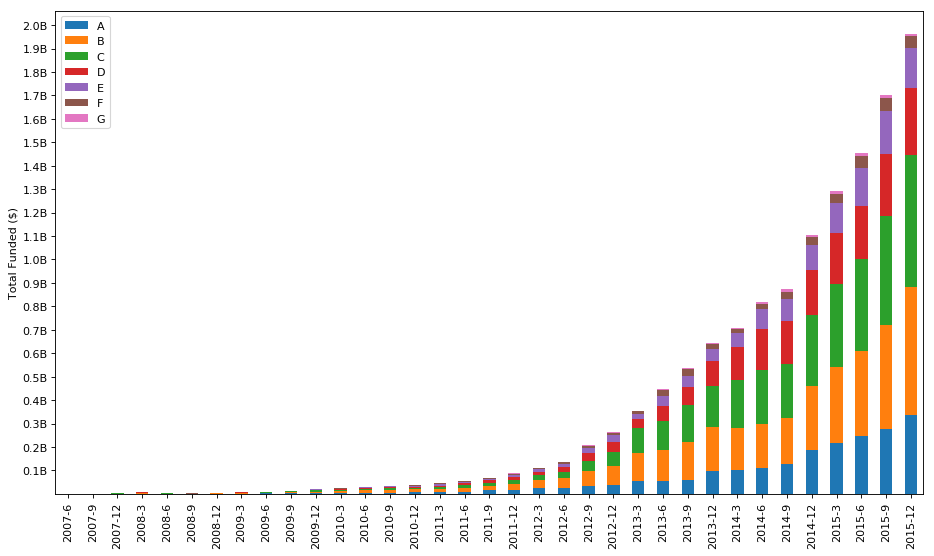

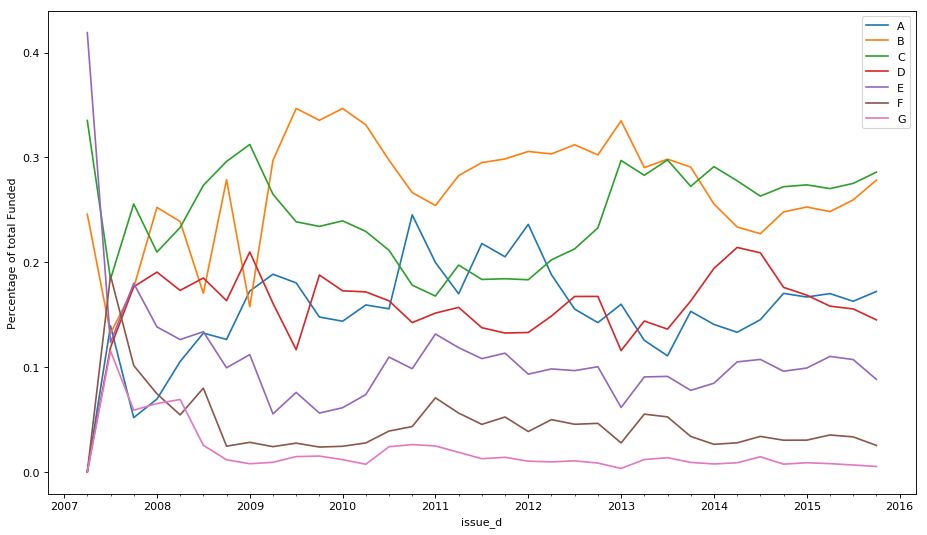

In [8]:
def make_loan_volume_plot(df):
    fig=plt.figure(figsize=(14, 8), dpi= 80, facecolor='w', edgecolor='k')
    ax = plt.gca()
    grp = df[['funded_amnt', 'grade', 'issue_d']].groupby(['issue_d', 'grade']).sum().unstack()
    grp2 = grp.groupby(pd.Grouper(level='issue_d', freq='3M')).sum()
    new_inds = [str(i.year)+"-"+str(i.month) for i in grp2.index]
    new_cols = ['G', 'F', 'E', 'D', 'C', 'B', 'A']
    grp2.index = new_inds
    grp2.columns = new_cols
    grp2 = grp2[grp2.columns[::-1]]
    grp2.plot(kind='bar', stacked=True, ax=ax)
    ytick_labels = [str(i/10)+'B' for i in range(1, 21, 1)]
    y_tick_vals = [i*(10**8) for i in range(1,21)]
    plt.yticks(y_tick_vals, ytick_labels)
    ax.set_ylabel("Total Funded ($)")
    
    fig=plt.figure(figsize=(14, 8), dpi= 80, facecolor='w', edgecolor='k')
    ax = plt.gca()
    grp = df[['funded_amnt', 'grade', 'issue_d']].groupby(['issue_d', 'grade']).sum().unstack()
    grp2 = grp.groupby(pd.Grouper(level='issue_d', freq='3M')).sum()
    sums = grp2.sum(axis=1)
    grp2 = grp2.divide(sums, axis=0)
    new_cols = ['G', 'F', 'E', 'D', 'C', 'B', 'A'][::-1]
    grp2 = grp2[grp2.columns[::-1]]
    grp2.columns = new_cols
    grp2.plot(ax=ax)
    ax.set_ylabel("Percentage of total Funded")

    return

make_loan_volume_plot(enriched_data)

                  

In [9]:
def get_modified_installment(df, term):
    '''
    For borrowers who payoff their loans early figure out their "modified installment".
    ASSUMPTION: early payoff of loan is made in equal installments over time. 
    '''
    
    s = df.installment.copy()
    s.loc[
        df.loan_status.isin([
            "Fully Paid",
            "Does not meet the credit policy. Status:Fully Paid"
        ]) & (round((df.last_pymnt_d - df.issue_d) / np.timedelta64(1,"M")) < term)
    ] = df.total_pymnt / (round((df.last_pymnt_d - df.issue_d) / np.timedelta64(1, "M")))
    
    return s
    

def get_payment(df, statement_date, months_since_last_pymnt):
    '''
    return a series of payments for the given series of statement dates
    '''
    
    s = pd.Series(np.NaN, index=df.index)
    
    #case 1, statement is on or before last payment date.  Assume full payment was made
    s.loc[months_since_last_pymnt <= 0] = df.modified_installment

    #case 2, statement is after last payment date.  Assume 0 payment
    s.loc[months_since_last_pymnt > 0] = 0

    #case 3, statement is 5 months after payment date.  
    #Assume payment equals net recoveries (if there are any)
    s[months_since_last_pymnt == 5] = df.recoveries - df.collection_recovery_fee

    #case 4, statement is beyond last date of data set.  Future payments unknown, fill with NaN's
    s.loc[statement_date > LAST_PAYMENT_DATE] = np.NaN
    
    return s

def get_ROI(df, period, months_since_last_pymnt):
    '''
    return a series of ROIs for the given period
    '''
     
    s = pd.Series(np.NaN, index=df.index)

    #case 1, statement is before or on last payment date.
    #payment_to_date = installment*period
    s.loc[months_since_last_pymnt <= 0] = (
        (((df.modified_installment*period) - df.funded_amnt) / df.funded_amnt)
    )

    #case 2, statement is after last payment date, but before collections
    #payment_to_date = installment*(last_payment_d - issue_d)
    s.loc[(months_since_last_pymnt > 0) & (months_since_last_pymnt < 5)] = (
        (df.modified_installment*round(
            (df.last_pymnt_d - df.issue_d) / np.timedelta64(1,"M")
        ) - df.funded_amnt) / df.funded_amnt 
    )

    #case 3, statement is after collections.
    #Total payment = df.total_pymnt
    s.loc[(months_since_last_pymnt >= 5)] = (
        ((df.total_pymnt - df.funded_amnt) / df.funded_amnt)
    )
    
    return s


def get_payment_history_for_term(df, term):
    '''
    construct payment histories for each loan, by iterating through periods and
    figuring out payments and ROIs at each point in time.  
    '''

    df['modified_installment'] = get_modified_installment(df, term)

    for period in range(1, term+1):
        pymnt_name = str(period)+"_month_pymnt"
        ROI_name = str(period) +"_month_ROI"

        statement_date = (df.issue_d + pd.DateOffset(months = period))

        months_since_last_pymnt = round(
            (statement_date - df.last_pymnt_d) / np.timedelta64(1, 'M')
        ).astype(int)

        df[pymnt_name] = get_payment(df, statement_date, months_since_last_pymnt)
        df[ROI_name] = get_ROI(df, period, months_since_last_pymnt)

    return df

def get_pymnt_history(df):
    '''
    for given loan dataframe return timeseries dataframe for payment history 
    of 36-month-term and 60-month-term loans 
    '''

    df_3years = df.loc[df.term == 36, [
        'issue_d',
        'grade',
        'int_rate',
        'loan_status',
        'funded_amnt',
        'total_pymnt',
        'installment',
        'last_pymnt_d',
        'recoveries',
        'collection_recovery_fee'
    ]].copy()
    
    df_5years = df.loc[df.term == 60, [
        'issue_d',
        'grade',
        'int_rate',
        'loan_status',
        'funded_amnt',
        'total_pymnt',
        'installment',
        'last_pymnt_d',
        'recoveries',
        'collection_recovery_fee'
    ]].copy()
    
    df_3years = get_payment_history_for_term(df_3years, 36)
    df_5years = get_payment_history_for_term(df_5years, 60)
    
    
    return (df_3years, df_5years)

pymnts_3years, pymnts_5years = get_pymnt_history(enriched_data[~enriched_data.loan_is_open])
enriched_data = enriched_data.join(pymnts_3years['36_month_ROI'])
enriched_data = enriched_data.join(pymnts_5years['60_month_ROI'])

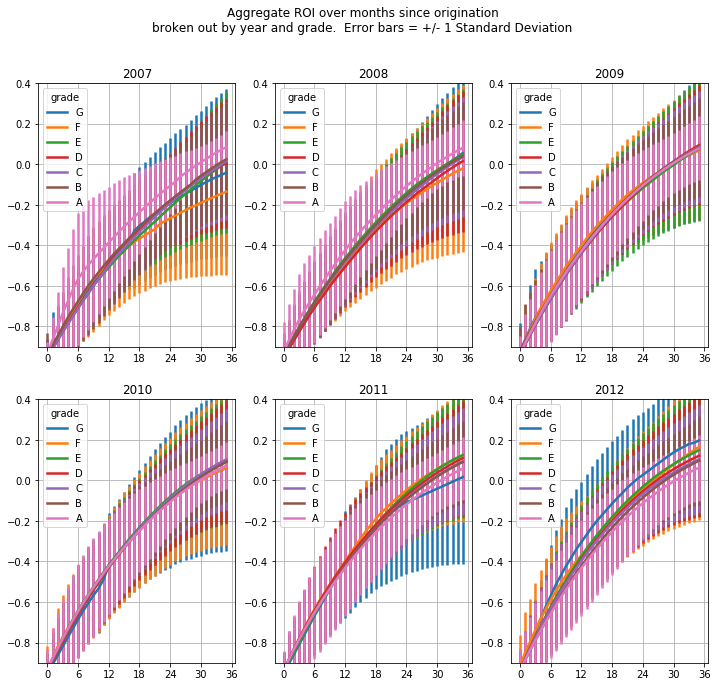

In [10]:
'''
Make ROI curves broken out by year and grade.
'''

def make_ROI_plot(df,term):
    ROI_columns = [str(i) +"_month_ROI" for i in range(1,term+1)]
    fig, ax_tuple = plt.subplots(2,3, figsize=(12, 10.66))
    ax_list = [ax for tupl in ax_tuple for ax in tupl]
    df['issue_year'] = df.issue_d.dt.year
    x_labels = [0,6,12,18,24,30,36]
    for i,y in enumerate([2007, 2008, 2009, 2010, 2011, 2012]):
        year_df = df.loc[df.issue_year == y]
        data = year_df[ROI_columns+['grade']].groupby('grade').mean().transpose()
        errors = year_df[ROI_columns+['grade']].groupby('grade').std().transpose()
        curr_ax = ax_list[i]
        data.plot(yerr = errors, ax=curr_ax, grid=True, ylim=(-.9, .4), title=y ,linewidth=2.5, xticks=x_labels, use_index=False)
    
    plt.suptitle("Aggregate ROI over months since origination"\
                "\nbroken out by year and grade.  Error bars = +/- 1 Standard Deviation")

make_ROI_plot(pymnts_3years, 36)


open           631141
closed_paid    209682
closed_bad      46006
Name: category, dtype: int64

funded_amnt                      
category  closed_bad closed_paid      open
issue_y                                   
2007        0.270035    0.729965       NaN
2008        0.207271    0.792729       NaN
2009        0.136906    0.863094       NaN
2010        0.139860    0.859023  0.001117
2011        0.147553    0.758252  0.094195
2012        0.151482    0.777255  0.071263
2013        0.110097    0.418511  0.471392
2014        0.059336    0.232205  0.708459
2015        0.006593    0.054646  0.938761

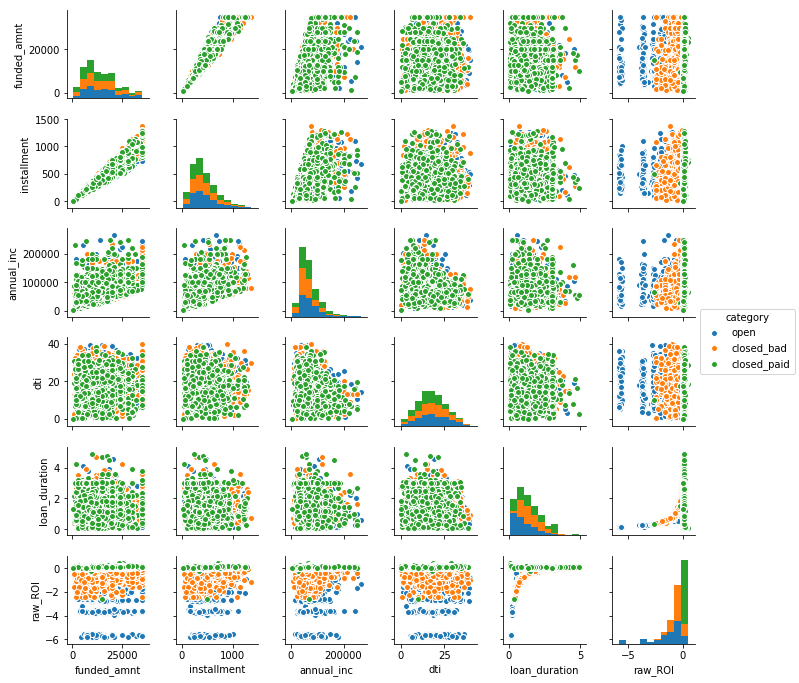

In [11]:
'''
explore the enriched data with some value counts and pair-wise distributions
'''

def outliers(df, col_name):
    return (np.abs(df[col_name] -df[col_name].mean()) / df[col_name].std()) >= 3

cont = enriched_data[[
    'funded_amnt',
    'installment',
    'annual_inc',
    'dti',
    'loan_duration',
    'loan_is_open',
    'loan_status',
    'raw_ROI',
    'issue_d'
]].copy()

cont['category'] = ""
cont.loc[cont.loan_is_open, "category"] = "open"
cont.loc[
    (~cont.loan_is_open) & 
    cont.loan_status.isin(
        ["Fully Paid", "Does not meet the credit policy. Status:Fully Paid"]
    ), "category"] = "closed_paid"
cont.loc[
    (~cont.loan_is_open) & 
    cont.loan_status.isin(
        ["Charged Off", "Does not meet the credit policy. Status:Charged Off"]
    ), "category"] = "closed_bad"
cont['issue_y'] = cont.issue_d.dt.year
display(cont.category.value_counts())
grps = cont[['funded_amnt','category', 'issue_y']].groupby(['issue_y','category']).count().unstack()
sums = grps.sum(axis=1)
grp2 = grps.divide(sums, axis=0)
display(grp2)
cont = cont[~outliers(cont, 'annual_inc')]
cont = cont[~outliers(cont, 'dti')]
cont = cont[~outliers(cont, 'raw_ROI')]
cont = cont.drop(['loan_status', 'loan_is_open', 'issue_d', 'issue_y'], axis=1)
cont_open = cont[cont.category == 'open'].sample(n=1000, replace=False)
cont_bad = cont[cont.category == 'closed_bad'].sample(n=1000, replace=False)
cont_good = cont[cont.category == 'closed_paid'].sample(n=1000, replace=False)
cont_final = pd.concat([cont_open, cont_bad, cont_good])
g = sns.pairplot(data=cont_final, hue="category", size=1.6)




In [12]:
'''
Use calculated ROIs and groupby to determine expected returns and volatility
broken out by grade and year
'''
def get_groups(df, term, method, new_name):
    _df = df.loc[df.term == term].copy()
    ROI_col = "{}_month_ROI".format(term) 
    grps = _df[
        [ROI_col, "grade", "issue_y", "term"]
    ].groupby(["issue_y", "term", "grade"]).agg(method)
    grps = grps.unstack(level=0).rename(columns={ROI_col:new_name}) \
        .sort_index(axis=0, level=1, ascending=False)
    return(grps)
        

def calc_expected_return_2(enriched_data):
    
    _df = enriched_data.loc[enriched_data.issue_d < dt.date(2013,1,1)].copy()
    _df['issue_y'] = _df.issue_d.dt.year
    
    means_36 = get_groups(_df, 36, "mean", "ROI")
    means_60 = get_groups(_df, 60, "mean", "ROI")
        
    means_all = pd.concat([means_36, means_60])
    means_all['AVG'] = means_all.mean(axis=1)
    means_all['+/-'] = means_all.std(axis=1)
    display((means_all*100).round(2))
    
    std_36 = get_groups(_df, 36, "std", "Vol.")
    std_60 = get_groups(_df, 60, "std", "Vol.")
        
    std_all = pd.concat([std_36, std_60])
    std_all['AVG'] = std_all.mean(axis=1)
    std_all['+/-'] = std_all.std(axis=1)
    display((std_all*100).round(2))


                
calc_expected_return_2(enriched_data)


ROI                                    AVG   +/-
issue_y      2007  2008  2009   2010   2011   2012            
term grade                                                    
36   A       8.58  8.16  7.91   7.39   5.90   6.35  7.38  0.97
     B       2.56  4.04  8.14   9.21   9.11   9.76  7.14  2.79
     C       1.65  3.57  8.61  10.43   9.47  10.44  7.36  3.46
     D       0.53  1.58  9.51   9.33  11.03  12.18  7.36  4.57
     E       0.99  4.74  7.66   9.97  12.59  14.95  8.48  4.68
     F     -13.44 -2.02  6.93   6.24  12.29  16.59  4.43  9.83
     G      -4.06  5.55  7.66   6.21   1.65  19.76  6.13  7.22
60   A        NaN   NaN   NaN  10.45   7.17   5.14  7.59  2.19
     B        NaN   NaN   NaN  11.66   5.53   1.90  6.36  4.03
     C        NaN   NaN   NaN  14.01   5.18   1.66  6.95  5.19
     D        NaN   NaN   NaN  15.51   4.60  -0.39  6.57  6.64
     E        NaN   NaN   NaN  16.72   7.16  -0.58  7.76  7.08
     F        NaN   NaN   NaN  18.43   5.64   0.92  8.33  7.40
     G        NaN   NaN   NaN  18.95   5.59  -3.36  7.06  9.16

Vol.                                       AVG   +/-
issue_y      2007   2008   2009   2010   2011   2012             
term grade                                                       
36   A       8.01  13.67  15.87  11.69  15.34  16.29  13.48  2.89
     B      27.71  26.56  24.38  19.99  20.36  21.87  23.48  2.96
     C      28.91  29.72  27.77  24.95  26.43  26.73  27.42  1.59
     D      31.94  34.84  29.47  30.18  28.34  30.45  30.87  2.08
     E      34.76  32.51  35.00  31.68  31.26  32.37  32.93  1.44
     F      41.14  41.29  34.61  38.06  32.58  36.31  37.33  3.21
     G      41.20  38.35  35.80  40.98  42.80  36.58  39.28  2.56
60   A        NaN    NaN    NaN  18.43  21.30  22.06  20.60  1.56
     B        NaN    NaN    NaN  30.05  30.94  32.84  31.28  1.16
     C        NaN    NaN    NaN  35.24  37.88  37.33  36.82  1.14
     D        NaN    NaN    NaN  39.09  41.38  41.56  40.68  1.13
     E        NaN    NaN    NaN  40.99  43.44  42.89  42.44  1.05
     F        NaN    NaN    NaN  40.11  47.03  44.95  44.03  2.90
     G        NaN    NaN    NaN  47.56  49.36  46.70  47.88  1.11

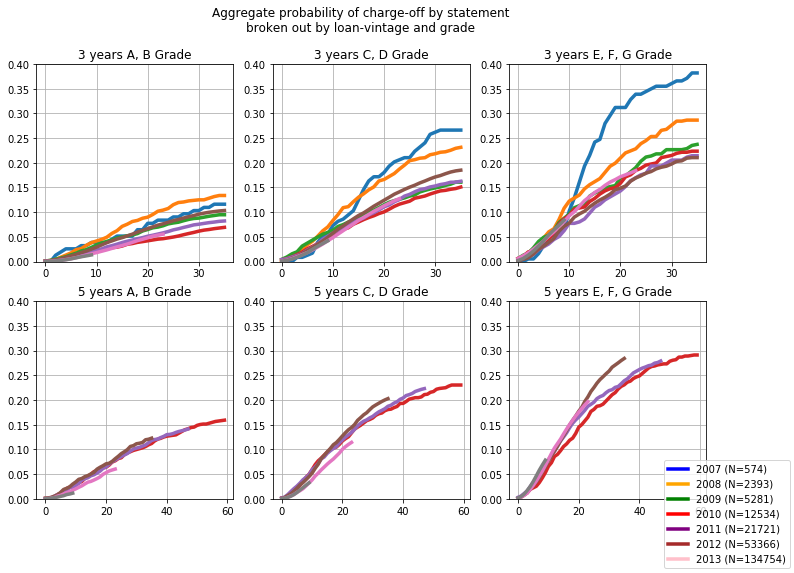

In [13]:
'''
make "p-bad" by vintage plots.
'''


def calc_p_bad(vintage, period, total):
    '''
    for a given vintage calculate the percentage of loans whose last
    payment date was before loan maturity, and the loan status was not
    fully paid or current.  ASSUMPTION: these reflect non-performing
    loans
    '''
    if (total == 0):
        return np.NAN

    return (
        (
            (
                vintage.last_pymnt_d < (
                    vintage.issue_d + pd.DateOffset(months = period)
                ) 
            ) & (
                vintage.loan_status.isin([
                    "Charged Off",
                    "Default",
                    "Does not meet the credit policy. Status:Charged Off",
                ])
            )
        ).sum() / total)

def make_vintages_plot(df):
    '''
    compare p-bad rates for loans originated in different quarters from
    2007-6-1 to 2015-1-1.  We want at least a 1-year period to see if the
    loan performs.  NOTE: despite accounting for 8 of the 9 years of historical
    data, this only captures about half of the loans in the data set.
    '''
    
    def make_subplot(df, term, periods, ax_handle, title):
        
        for i in range(len(vintage_intervals)-1):
            start_date = vintage_intervals[i]
            stop_date = vintage_intervals[i+1]
            vintage = df[(df.issue_d >= start_date)
                            & (df.issue_d < stop_date)] 
            total = vintage.shape[0]

                
            p_bads = []
            for n in range(1, term + 1):
                if((stop_date + relativedelta(months=n)) > LAST_PAYMENT_DATE):
                    break
                p_bad = calc_p_bad(vintage, n, total)
                p_bads.append(p_bad)
            ax_handle.plot(p_bads, linewidth=3.5)
            ax_handle.set_title(title)
        return(ax_handle)


    vintage_intervals = [
        dt.date(2008,1,1) + relativedelta(months=x) for x in range(0,91,12) #91
    ]
    vintage_intervals.insert(0, dt.date(2007,6,1))
    vintage_intervals[-1] += relativedelta(days=1, months=1)

    fig, ((ax_1, ax_2, ax_3),(ax_4, ax_5, ax_6)) = plt.subplots(2,3, figsize=(12, 8))

    tranch_1_3year = df[df.grade.isin(['A', 'B']) & (df.term == 36)]
    tranch_2_3year = df[df.grade.isin(['C', 'D']) & (df.term == 36)]
    tranch_3_3year = df[df.grade.isin(['E', 'F', 'G']) & (df.term == 36)]
    
    tranch_1_5year = df[df.grade.isin(['A', 'B']) & (df.term == 60)]
    tranch_2_5year = df[df.grade.isin(['C', 'D']) & (df.term == 60)]
    tranch_3_5year = df[df.grade.isin(['E', 'F', 'G']) & (df.term == 60)]

    ax_1 = make_subplot(tranch_1_3year, 36,
                        vintage_intervals, ax_1,
                        "3 years A, B Grade")
    ax_1.set_ylim([0, .4])
    ax_1.grid()

    ax_2 = make_subplot(tranch_2_3year, 36,
                        vintage_intervals, ax_2,
                        "3 years C, D Grade")  
    ax_2.set_ylim([0, .4])
    ax_2.grid()
    
    ax_3 = make_subplot(tranch_3_3year, 36,
                        vintage_intervals, ax_3,
                        "3 years E, F, G Grade")  
    ax_3.set_ylim([0, .4])
    ax_3.grid()

    ax_4 = make_subplot(tranch_1_5year, 60,
                        vintage_intervals, ax_4,
                        "5 years A, B Grade")  
    ax_4.set_ylim([0, .4])
    ax_4.grid()

    ax_5 = make_subplot(tranch_2_5year, 60,
                        vintage_intervals, ax_5,
                        "5 years C, D Grade")  
    ax_5.set_ylim([0, .4])
    ax_5.grid()

    ax_6 = make_subplot(tranch_3_5year, 60,
                        vintage_intervals, ax_6,
                        "5 years E, F, G Grade")  
    ax_6.set_ylim([0, .4])
    ax_6.grid()

    line_handles = [
        mlines.Line2D([], [], color='blue', linewidth=3.5, label='2007'),
        mlines.Line2D([], [], color='orange', linewidth=3.5, label='2008'),
        mlines.Line2D([], [], color='green', linewidth=3.5, label='2009'),
        mlines.Line2D([], [], color='red', linewidth=3.5, label='2010'),
        mlines.Line2D([], [], color='purple', linewidth=3.5, label='2011'),
        mlines.Line2D([], [], color='brown', linewidth=3.5, label='2012'),
        mlines.Line2D([], [], color='pink', linewidth=3.5, label='2013'),
        mlines.Line2D([], [], color='grey', linewidth=3.5, label='2014')
    ]  
    
    value_counts = df.issue_d.dt.year.value_counts()
    years = list(value_counts.index)[2:]
    years.reverse()
    
    cnts = list(value_counts.values)[2:]
    cnts.reverse()
    labels = ["{} (N={})".format(y,c) for y,c in zip(years,cnts)]
    
    fig.suptitle("Aggregate probability of charge-off by statement" \
                 "\nbroken out by loan-vintage and grade")
    fig.legend(line_handles, labels, 'lower right')
    plt.show()

make_vintages_plot(enriched_data)


In [14]:
'''
Prepare Data for modeling.  NOTE: modeling is restricted to 36 month term loans.
I chose to treat this as a regression task, in which features present at loan
origination are used to predict the ROI obtained after holding the loan for
36 months.

This means that 3-full years of payment history are needed for loans in BOTH
training and testing data.  2012 is the last vintage which has a full payment
history in the dataset.  This restricts training to the 2007, 2008, and
2009 vintages.  This is problematic because the 2007 and 2008 vintages had
anamolous behavior due to the financial recession.

'''

def get_features_post_split(df):
        '''
        These features considered population-level statistics and thus need to be added 
        after train-test splits.
        '''

        _df = df.copy()
        
        def zscore(s):
            return (s - s.mean()) / s.std()

        features = ["annual_inc", "funded_amnt", "int_rate", "dti"]
        groups = ["grade", "purpose", "addr_state"]
        for f in features:
            for g in groups:
                name = "zscore_{}_by_{}".format(f,g)
                _df[name] = np.NaN
                _df[name] = _df.groupby([_df[g]])[f].transform(zscore)
                _df[name] = _df[name].fillna(_df[name].median())
                _df[name] = _df[name].fillna(0)

        return _df

    
def prepare_modeling(df, scaler=None, use_scaling=True, use_dummies=True):
    '''
    This function prepares date for modeling.  Based upon arguments it will scale 
    (i.e. recenter to mean=0 var=1) and dummy variables.  Additionally, it drops
    features that aren't useful for modeling / wouldn't be present at loan-origination
    '''

    _df = df.copy()
    
    target_column = "36_month_ROI"

    standard_scale_cols = [
        'funded_amnt', 'int_rate', 'grade', 'sub_grade', 'emp_length',
        'annual_inc', 'dti', 'delinq_2yrs', 'installment', 'inq_last_6mths',
        'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
        'earliest_cr_delta', 'revol_limit', 'avg_revol_acc_limit',
        'avg_revol_acc_bal', 'percentage_funded', 'inst_to_income',
        'issue_days_since_start', 'issue_d_year'
    ]
    
    drop_cols = [
        'loan_amnt', 'issue_d', 'loan_status', 'zip_code', 'earliest_cr_line',
        'funded_amnt_inv', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
        'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int','total_rec_int',
        'total_rec_late_fee','recoveries', 'term', 'collection_recovery_fee',
        'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
        'loan_is_open', 'maturity_d', 'loan_duration', 'term_ROI', 'raw_ROI',
        '60_month_ROI'
    ]


    df = get_features_post_split(_df)
    if use_dummies:
        dummy_cols = [
            'home_ownership', 'verification_status', 'purpose', 'initial_list_status', 'addr_state'
        ]
        df = pd.get_dummies(df, columns=dummy_cols)
        cat_columns = ['grade', 'sub_grade']
        df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

    df['issue_days_since_start'] = (df.issue_d - EARLIEST_ISSUE).dt.days
    df = df.drop(drop_cols, axis=1)

    X = df.loc[:, df.columns != target_column]
    Y = df[target_column]

    if(not scaler):
        scaler = StandardScaler()

    if use_scaling:
        X[standard_scale_cols] = scaler.fit_transform(X[standard_scale_cols])

    return X, Y, scaler


def split(df, train_start_date=dt.date(2007,1,1), train_end_date=dt.date(2009,1,1),
          test_start_date=dt.date(2012,1,1), test_end_date=dt.date(2013,1,1),
          use_scaling=True, use_dummies=True):
    '''
    Divide data into training and test splits, with final modeling features, category-encoding, 
    and scaling.  Simplifying assumptions: only model 3 year loans with full payment histories.
    That restricts universe to issue dates before 2013-1-1

    '''

    train = df.loc[(~df.loan_is_open) &
                  (df.issue_d >= train_start_date) &
                  (df.issue_d < train_end_date) &
                  (df.term == 36)].copy()
    
    test = df.loc[(~df.loan_is_open) &
                  (df.issue_d >= test_start_date) &
                  (df.issue_d < test_end_date) &
                  (df.term == 36)].copy()
   
           
    train_x, train_y, scaler = prepare_modeling(train, None, use_scaling, use_dummies)
    test_x, test_y, _ = prepare_modeling(test, scaler, use_scaling, use_dummies)
    print("SIZE OF TRAIN {}".format(train_x.shape))
    print("SIZE OF TEST {}".format(test_x.shape))
    return ((train_x, train_y), (test_x, test_y))

((train_x, train_y), (test_x, test_y)) = split(enriched_data, use_scaling=False, use_dummies=True)

SIZE OF TRAIN (2967, 118)
SIZE OF TEST (43332, 118)


Training MED. ABS. ERROR: 0.1367
Training baseline MED. ABS ERROR: 0.2188
Testing MED. ABS. ERROR: 0.1503
Testing baseline MED. ABS ERROR: 0.1810


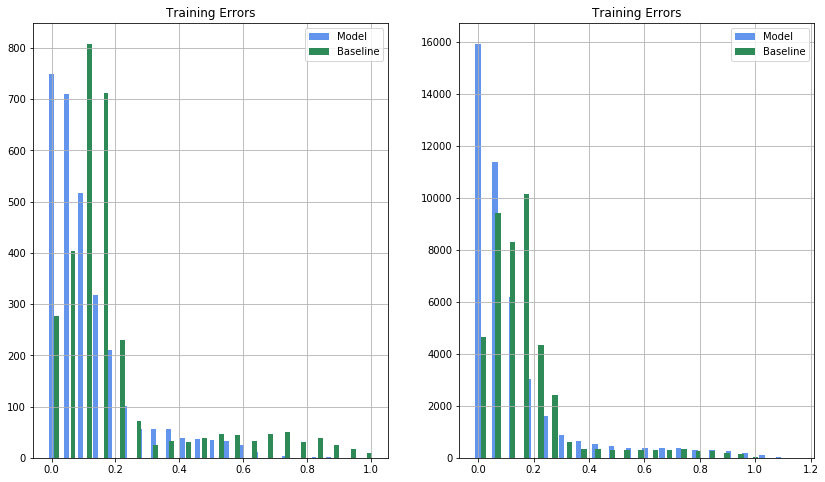

In [15]:
'''
For the given, training data, testing data, and model return in-sample 
and out-sample modeling statistics and plots.

A baseline is included for comparison sake.  It finds the mean of the ROI
for the training set and uses it as a constant prediction value 
'''

def get_predictions(X_train, Y_train, X_test, Y_test, model, make_plots=True):
   
    X_train_values = X_train.values
    Y_train_values = Y_train.values
    X_test_values = X_test.values
    Y_test_values = Y_test.values
    
    model.fit(X_train, Y_train)
    in_sample = model.predict(X_train)
    out_sample = model.predict(X_test)
    baseline_pred_train = [Y_train_values.mean()]*Y_train.shape[0]
    baseline_pred_test = [Y_train_values.mean()]*Y_test.shape[0]
    
    
    print(
        "Training MED. ABS. ERROR: {:.4f}".format(
            mean_absolute_error(Y_train_values, in_sample)
        )
    )
    
    print(
        "Training baseline MED. ABS ERROR: {:.4f}".format(
            mean_absolute_error(Y_train_values, baseline_pred_train)
        )
    )
    
    print(
        "Testing MED. ABS. ERROR: {:.4f}".format(
            mean_absolute_error(Y_test_values, out_sample)
        )
    )
                  
    print(
        "Testing baseline MED. ABS ERROR: {:.4f}".format(
            mean_absolute_error(Y_test_values, baseline_pred_test)
        )
    )
    
    if make_plots:
        fig, (ax_1, ax_2) = plt.subplots(1,2, figsize=(14,8))

        m_train = pd.Series(np.abs(Y_train_values - in_sample))
        bl_train = pd.Series(np.abs(Y_train_values - baseline_pred_train))
        m_test = pd.Series(np.abs(Y_test_values - out_sample))
        bl_test = pd.Series(np.abs(Y_test_values - baseline_pred_test), name='d')

        a_heights, a_bins = np.histogram(m_train, bins=20)
        b_heights, b_bins = np.histogram(bl_train, bins=20)
        width = (a_bins[1] - a_bins[0])/3
        
        ax_1.bar(a_bins[:-1], a_heights, width=width, facecolor='cornflowerblue', label="Model")
        ax_1.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='seagreen', label="Baseline")
        ax_1.set_title("Training Errors")
        ax_1.grid()
        ax_1.legend()
        
        a_heights, a_bins = np.histogram(m_test, bins=20)
        b_heights, b_bins = np.histogram(bl_test, bins=20)
        width = (a_bins[1] - a_bins[0])/3
        
        ax_2.bar(a_bins[:-1], a_heights, width=width, facecolor='cornflowerblue', label="Model")
        ax_2.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='seagreen', label="Baseline")
        ax_2.set_title("Training Errors")
        ax_2.grid()
        ax_2.legend()
    

    in_sample_pred = pd.Series(in_sample, index=Y_train.index, name="in_sample_ROI")
    out_sample_pred = pd.Series(out_sample, index=Y_test.index, name="out_sample_ROI")
    return(in_sample_pred, out_sample_pred)


#svr_rbf = SVR(kernel='rbf', C= 100, gamma= .01)

m = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    random_state=0,
    loss='ls',
    min_samples_split=20,
    max_features="sqrt",
    subsample=.8
)

m = GradientBoostingRegressor(
    n_estimators=800,
    learning_rate=0.025,
    max_depth=4,
    loss='ls',
    min_samples_split=4,
    min_samples_leaf=2,
    max_features="sqrt",
    subsample=.8
)

in_sample_pred, out_sample_pred = get_predictions(train_x, train_y, test_x, test_y, m)
pred_data = enriched_data.join(in_sample_pred)
pred_data = pred_data.join(out_sample_pred)

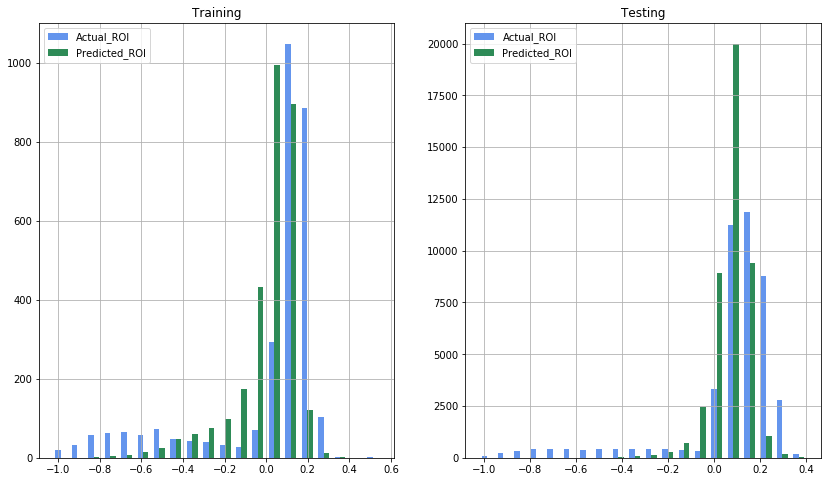

In [16]:
'''
Plot histograms of ROI predictions for baseline and model on training and test sets
'''

def make_prediction_hists(df):
    
    fig, ax_list = plt.subplots(1,2, figsize=(14,8))
    titles = ["Training", "Testing"]
    for i, pred_col in enumerate(["in_sample_ROI", "out_sample_ROI"]):
        ax_handle = ax_list[i] 
        hist_data = df.loc[~df[pred_col].isnull(), ["36_month_ROI", pred_col]]
        a_heights, a_bins = np.histogram(hist_data['36_month_ROI'], bins=20)
        b_heights, b_bins = np.histogram(hist_data[pred_col], bins=a_bins)
        width = (a_bins[1] - a_bins[0])/3
        
        ax_handle.bar(a_bins[:-1], a_heights, width=width, facecolor='cornflowerblue', label="Actual_ROI")
        ax_handle.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='seagreen', label="Predicted_ROI")
        ax_handle.set_title(titles[i])
        ax_handle.grid()
        ax_handle.legend()
    
    return

make_prediction_hists(pred_data)

Training
Avg. 36 month ROI for Oracle Portfolio: 29.69
Avg. 36 month ROI for Baseline Portfolio: -4.61
Avg. 36 month ROI for Model Portfolio: 24.91

Testing
Avg. 36 month ROI for Oracle Portfolio: 40.31
Avg. 36 month ROI for Baseline Portfolio: 13.77
Avg. 36 month ROI for Model Portfolio: 12.29



Text(0,0.5,'ROI')

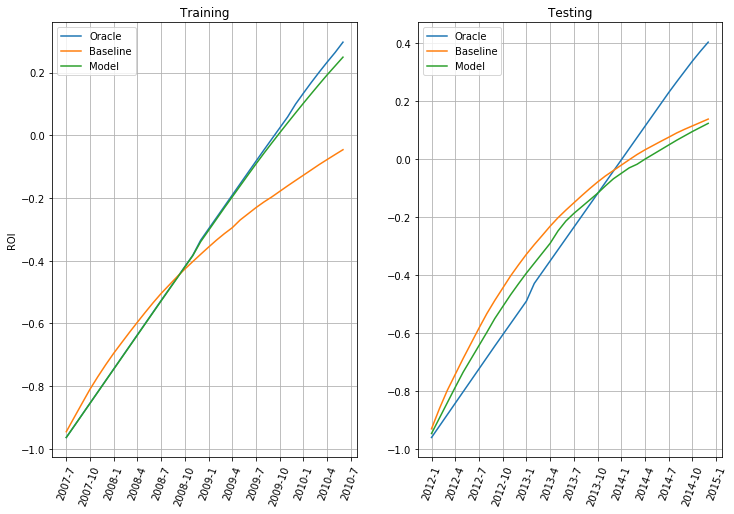

In [17]:
'''
Compare the 36 month ROI curves for all agents on test and train sets.  Configurable paremeter of portfolio size.
'''

def make_oracle_loanbook(df, portfolio_size):
    '''
    oracle agent always picks highest ROI loans
    '''

    oracle_data = df.copy()
    oracle_data.sort_values(by=['36_month_ROI'], ascending=False, inplace=True)
    oracle_data = oracle_data[oracle_data.loan_amnt.cumsum() <= portfolio_size]
    
    return oracle_data

def make_baseline_loanbook(df, portfolio_size):
    '''
    baseline agent randomly selects loans
    '''
    
    baseline_data = df.copy()
    baseline_data = shuffle(baseline_data, random_state=1234)
    baseline_data = baseline_data[baseline_data.loan_amnt.cumsum() <= portfolio_size]
    return baseline_data

def make_model_loanbook(df, portfolio_size, train_flag):
    '''
    model agent picks highest predicted ROI loans
    '''
    
    target_col = "out_sample_ROI"
    if train_flag:
        target_col = "in_sample_ROI"
    
    model_data = df.copy()
    model_data.sort_values(by=target_col, ascending=False, inplace=True)
    model_data = model_data[model_data.loan_amnt.cumsum() <= portfolio_size]
    return model_data



def make_comparison_plot(df, portfolio_size, train_flag, ax_handle):
    
    _df = df.copy()

    title = "Testing"
    if train_flag:
        title = "Training"
        
    ROI_columns = [str(i) +"_month_ROI" for i in range(1,37)]
    
    oracle_lb = make_oracle_loanbook(_df, portfolio_size)
    base_lb = make_baseline_loanbook(_df, portfolio_size)
    model_lb = make_model_loanbook(_df, portfolio_size, train_flag)
    
    year3_oracle_pymnt, _ = get_pymnt_history(oracle_lb)
    year3_baseline_pymnt, _ = get_pymnt_history(base_lb)
    year3_model_pymnt, _ = get_pymnt_history(model_lb)
    
    print(title)
    print("Avg. 36 month ROI for Oracle Portfolio: {:0.2f}".format(
        year3_oracle_pymnt["36_month_ROI"].mean()*100
    ))
    
    print("Avg. 36 month ROI for Baseline Portfolio: {:0.2f}".format(
        year3_baseline_pymnt["36_month_ROI"].mean()*100
    ))
    
    print("Avg. 36 month ROI for Model Portfolio: {:0.2f}\n".format(
        year3_model_pymnt["36_month_ROI"].mean()*100
    ))
          
    
    year3_oracle_pymnt[ROI_columns].mean().transpose().plot(ax=ax_handle, label="Oracle")
    year3_baseline_pymnt[ROI_columns].mean().transpose().plot(ax=ax_handle, label="Baseline", grid=True)
    year3_model_pymnt[ROI_columns].mean().transpose().plot(ax=ax_handle, label ="Model", grid=True, title=title)
    ax_handle.legend()
    return
  
pred_data_train = pred_data[~pred_data.in_sample_ROI.isnull()]
pred_data_test = pred_data[~pred_data.out_sample_ROI.isnull()]
fig, (ax_1, ax_2) = plt.subplots(1,2,figsize=(12,8))



make_comparison_plot(pred_data_train, 1*10**6, True, ax_1)
xtick_labels = [dt.datetime(2007,7,1) + relativedelta(months=3*i) for i in range(0, 13)]
xtick_labels = [str(d.year)+"-"+str(d.month) for d in xtick_labels]  
x_tick_vals = [i for i in range(0, 37, 3)]
ax_1.xaxis.set_ticks(x_tick_vals)
ax_1.xaxis.set_ticklabels(xtick_labels, rotation=70)

make_comparison_plot(pred_data_test, 1*10**6, False, ax_2)
xtick_labels = [dt.datetime(2012,1,1) + relativedelta(months=3*i) for i in range(0, 13)]
xtick_labels = [str(d.year)+"-"+str(d.month) for d in xtick_labels]  
x_tick_vals = [i for i in range(0, 37, 3)]
ax_2.xaxis.set_ticks(x_tick_vals)
ax_2.xaxis.set_ticklabels(xtick_labels, rotation=70)
ax_1.set_ylabel('ROI')


In [21]:
'''
run simulations - NOTE this can take ~ 10 minutes to run as 
it trains and tests the model for 10 epochs, against 12 rolling-month windows
'''

def run_comparisons(df, m, portfolio_size=10**6):
   
    training_start = dt.date(2007,7,1)
    
    
    oracle_results = np.zeros((10,12))
    baseline_results = np.zeros((10,12))
    model_results = np.zeros((10,12))
    
    for j in range(10):
        print(color.RED + 'Epoch {}'.format(j) + color.RED)
        
        for i in range(12):
            _df = df.copy()
            #training_start += relativedelta(months=1)
            training_end = training_start + relativedelta(months=(18+i))
            test_start = training_end + relativedelta(years=3)
            test_end = test_start + relativedelta(months=1)

            print(color.BLUE+"TRAINING: {} to {}. TESTING: {} to {}".format(
                training_start, training_end, test_start, test_end) +color.END 
                 )

            ((train_x, train_y), (test_x, test_y)) = split(
                _df, 
                train_start_date=training_start,
                train_end_date=training_end,
                test_start_date=test_start,
                test_end_date=test_end,
                use_scaling=False,
                use_dummies=True
            )
            _, out_sample_pred = get_predictions(train_x, train_y, test_x, test_y, m, False)

            _df = _df.join(out_sample_pred, how='inner').copy()

            results_data = _df[['36_month_ROI', 'out_sample_ROI', 'funded_amnt']]

            #get oracle results for loans in test-period
            results_data.sort_values(by=['36_month_ROI'], ascending=False, inplace=True)
            oracle_result = results_data.loc[
                (results_data.funded_amnt.cumsum() <= portfolio_size),
                "36_month_ROI"
            ].copy().mean()
            oracle_results[j][i] = oracle_result

            #get baseline results for loans in test-period
            baseline_data = results_data.copy()
            baseline_data = shuffle(baseline_data)
            baseline_result = baseline_data.loc[
                (baseline_data.funded_amnt.cumsum() <= portfolio_size),
                "36_month_ROI"
            ].mean()
            baseline_results[j][i] = baseline_result


            #get model results for loans in test-period
            results_data.sort_values(by=['out_sample_ROI'], ascending=False, inplace=True)
            model_result = results_data.loc[
                (results_data.funded_amnt.cumsum() <= portfolio_size),
                "36_month_ROI"
            ].copy().mean()
            model_results[j][i] = model_result
        
    return(oracle_results, baseline_results, model_results)
    
m = GradientBoostingRegressor(
    n_estimators=800,
    learning_rate=0.025,
    max_depth=4,
    loss='ls',
    min_samples_split=4,
    min_samples_leaf=2,
    max_features="sqrt",
    subsample=.8
)
   
o_res, bl_res, mdl_res = run_comparisons(enriched_data, m, portfolio_size=(10**6))
        
         
        
        

Epoch 0
TRAINING: 2007-07-01 to 2009-01-01. TESTING: 2012-01-01 to 2012-02-01
SIZE OF TRAIN (2964, 118)
SIZE OF TEST (2058, 118)
Training MED. ABS. ERROR: 0.1394
Training baseline MED. ABS ERROR: 0.2189
Testing MED. ABS. ERROR: 0.1455
Testing baseline MED. ABS ERROR: 0.1685


/home/peter/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/peter/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


TRAINING: 2007-07-01 to 2009-02-01. TESTING: 2012-02-01 to 2012-03-01
SIZE OF TRAIN (3233, 118)
SIZE OF TEST (2083, 118)
Training MED. ABS. ERROR: 0.1390
Training baseline MED. ABS ERROR: 0.2151
Testing MED. ABS. ERROR: 0.1426
Testing baseline MED. ABS ERROR: 0.1698
TRAINING: 2007-07-01 to 2009-03-01. TESTING: 2012-03-01 to 2012-04-01
SIZE OF TRAIN (3535, 118)
SIZE OF TEST (2357, 118)
Training MED. ABS. ERROR: 0.1399
Training baseline MED. ABS ERROR: 0.2107
Testing MED. ABS. ERROR: 0.1356
Testing baseline MED. ABS ERROR: 0.1602
TRAINING: 2007-07-01 to 2009-04-01. TESTING: 2012-04-01 to 2012-05-01
SIZE OF TRAIN (3859, 118)
SIZE OF TEST (2680, 118)
Training MED. ABS. ERROR: 0.1401
Training baseline MED. ABS ERROR: 0.2060
Testing MED. ABS. ERROR: 0.1351
Testing baseline MED. ABS ERROR: 0.1611
TRAINING: 2007-07-01 to 2009-05-01. TESTING: 2012-05-01 to 2012-06-01
SIZE OF TRAIN (4192, 118)
SIZE OF TEST (2741, 118)
Training MED. ABS. ERROR: 0.1417
Training baseline MED. ABS ERROR: 0.2029
Test

TRAINING: 2007-07-01 to 2009-08-01. TESTING: 2012-08-01 to 2012-09-01
SIZE OF TRAIN (5368, 118)
SIZE OF TEST (4460, 118)
Training MED. ABS. ERROR: 0.1431
Training baseline MED. ABS ERROR: 0.1940
Testing MED. ABS. ERROR: 0.1534
Testing baseline MED. ABS ERROR: 0.1689
TRAINING: 2007-07-01 to 2009-09-01. TESTING: 2012-09-01 to 2012-10-01
SIZE OF TRAIN (5814, 118)
SIZE OF TEST (5079, 118)
Training MED. ABS. ERROR: 0.1419
Training baseline MED. ABS ERROR: 0.1896
Testing MED. ABS. ERROR: 0.1545
Testing baseline MED. ABS ERROR: 0.1666
TRAINING: 2007-07-01 to 2009-10-01. TESTING: 2012-10-01 to 2012-11-01
SIZE OF TRAIN (6321, 118)
SIZE OF TEST (5182, 118)
Training MED. ABS. ERROR: 0.1418
Training baseline MED. ABS ERROR: 0.1867
Testing MED. ABS. ERROR: 0.1480
Testing baseline MED. ABS ERROR: 0.1651
TRAINING: 2007-07-01 to 2009-11-01. TESTING: 2012-11-01 to 2012-12-01
SIZE OF TRAIN (6925, 118)
SIZE OF TEST (5147, 118)
Training MED. ABS. ERROR: 0.1435
Training baseline MED. ABS ERROR: 0.1856
Test

TRAINING: 2007-07-01 to 2009-02-01. TESTING: 2012-02-01 to 2012-03-01
SIZE OF TRAIN (3233, 118)
SIZE OF TEST (2083, 118)
Training MED. ABS. ERROR: 0.1389
Training baseline MED. ABS ERROR: 0.2151
Testing MED. ABS. ERROR: 0.1427
Testing baseline MED. ABS ERROR: 0.1698
TRAINING: 2007-07-01 to 2009-03-01. TESTING: 2012-03-01 to 2012-04-01
SIZE OF TRAIN (3535, 118)
SIZE OF TEST (2357, 118)
Training MED. ABS. ERROR: 0.1399
Training baseline MED. ABS ERROR: 0.2107
Testing MED. ABS. ERROR: 0.1400
Testing baseline MED. ABS ERROR: 0.1602
TRAINING: 2007-07-01 to 2009-04-01. TESTING: 2012-04-01 to 2012-05-01
SIZE OF TRAIN (3859, 118)
SIZE OF TEST (2680, 118)
Training MED. ABS. ERROR: 0.1399
Training baseline MED. ABS ERROR: 0.2060
Testing MED. ABS. ERROR: 0.1395
Testing baseline MED. ABS ERROR: 0.1611
TRAINING: 2007-07-01 to 2009-05-01. TESTING: 2012-05-01 to 2012-06-01
SIZE OF TRAIN (4192, 118)
SIZE OF TEST (2741, 118)
Training MED. ABS. ERROR: 0.1420
Training baseline MED. ABS ERROR: 0.2029
Test

TRAINING: 2007-07-01 to 2009-08-01. TESTING: 2012-08-01 to 2012-09-01
SIZE OF TRAIN (5368, 118)
SIZE OF TEST (4460, 118)
Training MED. ABS. ERROR: 0.1431
Training baseline MED. ABS ERROR: 0.1940
Testing MED. ABS. ERROR: 0.1519
Testing baseline MED. ABS ERROR: 0.1689
TRAINING: 2007-07-01 to 2009-09-01. TESTING: 2012-09-01 to 2012-10-01
SIZE OF TRAIN (5814, 118)
SIZE OF TEST (5079, 118)
Training MED. ABS. ERROR: 0.1417
Training baseline MED. ABS ERROR: 0.1896
Testing MED. ABS. ERROR: 0.1517
Testing baseline MED. ABS ERROR: 0.1666
TRAINING: 2007-07-01 to 2009-10-01. TESTING: 2012-10-01 to 2012-11-01
SIZE OF TRAIN (6321, 118)
SIZE OF TEST (5182, 118)
Training MED. ABS. ERROR: 0.1414
Training baseline MED. ABS ERROR: 0.1867
Testing MED. ABS. ERROR: 0.1508
Testing baseline MED. ABS ERROR: 0.1651
TRAINING: 2007-07-01 to 2009-11-01. TESTING: 2012-11-01 to 2012-12-01
SIZE OF TRAIN (6925, 118)
SIZE OF TEST (5147, 118)
Training MED. ABS. ERROR: 0.1439
Training baseline MED. ABS ERROR: 0.1856
Test

Average Alpha: 2.37%


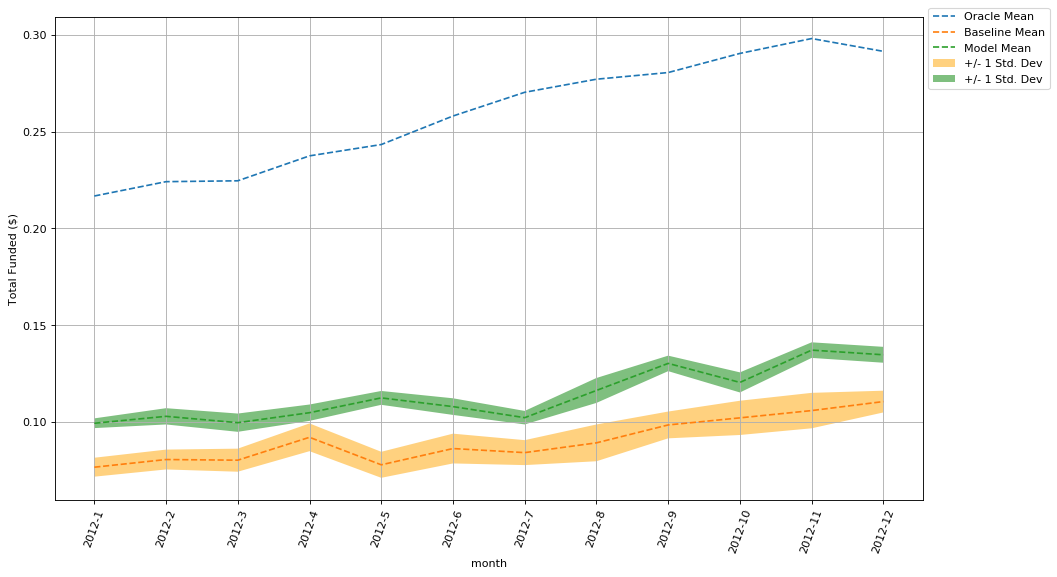

In [22]:
'''
plot simulation results with volatility 
'''
o_res_means = np.mean(o_res, axis=0)

bl_res_means = np.mean(bl_res, axis=0)
std = np.std(bl_res, axis=0)
bl_res_high = bl_res_means + std
bl_res_low = bl_res_means - std

mdl_res_means = np.mean(mdl_res, axis=0)
std = np.std(mdl_res, axis=0)
mdl_res_high = mdl_res_means + std
mdl_res_low = mdl_res_means - std

#Xs = [dt.datetime(2007,1,1) + relativedelta(months=1) for i in range(12)]
Xs = [i for i in range(12)]
fig=plt.figure(figsize=(14, 8), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.gca()
ax.plot(Xs, o_res_means, label='Oracle Mean', ls="--")

ax.plot(Xs, bl_res_means, label='Baseline Mean', ls="--")
ax.fill_between(
    Xs,
    bl_res_high,
    bl_res_low,
    facecolor='orange',
    alpha=0.5,
    label='+/- 1 Std. Dev'
)

ax.plot(Xs, mdl_res_means, label='Model Mean', ls="--")
ax.fill_between(
    Xs,
    mdl_res_high,
    mdl_res_low,
    facecolor='green',
    alpha=0.5,
    label='+/- 1 Std. Dev'
)

ax.legend(bbox_to_anchor=(1, 1.03))
ax.set_xlabel('month')
ax.set_ylabel('ROI')
xtick_labels = [dt.datetime(2012,1,1) + relativedelta(months=i) for i in range(0, 12)]
xtick_labels = [str(d.year)+"-"+str(d.month) for d in xtick_labels]  
x_tick_vals = [i for i in range(0, 12)]
plt.xticks(x_tick_vals, xtick_labels)
plt.xticks(rotation=70)
ax.set_ylabel("Total Funded ($)")
ax.grid()
print("Average Alpha: {:.2f}%".format((np.mean(mdl_res_means - bl_res_means))*100))
